# Question 3

Is there some (temporal) relation between the commenting activity and the decision to start “contributing to" a package? I would guess that new contributors/committers to the code of a package would first start by commenting to the package, and as they get more experiences they might go one step further and actually start submitting pull requests or even direct commits (depending on the development process followed)

In [37]:
import pandas
import matplotlib.pyplot as plt
import seaborn
import collections
import itertools
import numpy as np
import warnings
import subprocess
import requests
import lifelines


import sys
sys.path.append('..')

from helper import load_data , load_repo ,read_comments , GIT_API
warnings.filterwarnings('ignore')

%matplotlib inline

palet = seaborn.color_palette('hls', 8)[0:8]

In [2]:
cargo = load_repo('Cargo')
cargo_git = cargo[cargo.Repository_URL.notnull()]
cargo_git = cargo_git[cargo_git.Repository_URL.str.contains('github')].drop_duplicates(subset='Repository_URL')
repos = cargo_git[['Name','Repository_URL']].set_index('Repository_URL')

In [13]:
all_comments = (
    read_comments()
    .assign(created_at = lambda x: pandas.to_datetime(x['created_at']))
    [['Name','user_login','author_assoc','created_at','type']]
    .sort_values(['Name','user_login','created_at'])
    .drop_duplicates(['Name','user_login'],keep='first')
)

all_comments.head()

,Name,user_login,author_assoc,created_at,type
130628,actix,Anton-4,NONE,2018-02-05 18:39:23,isu
130790,actix,Brooooooklyn,NONE,2018-08-01 17:11:35,pul
130752,actix,Cocalus,CONTRIBUTOR,2018-09-22 20:14:28,pul
130644,actix,DGolubets,CONTRIBUTOR,2017-12-12 18:32:30,isu
130601,actix,DoumanAsh,CONTRIBUTOR,2018-03-15 06:52:05,isu


In [4]:
packages, dependencies = load_data('Cargo')
packages_dependencies = (
    packages.merge(dependencies,left_on=['package','version'], right_on=['package','version'])
    .sort_values(['package','date'])
    .reset_index()
    .drop('index',axis=1)
    .drop_duplicates(['package','target'],keep='first')
)

In [5]:
commits = pandas.read_csv('../data/commitlogs1.csv.gz',compression='gzip',parse_dates=['commit_date'])

In [6]:
selected_repos = (
    pandas.read_csv('../data/origin/selected_origins.csv')
    .append(pandas.read_csv('../data/depend/selected_dependencies.csv'))
)

In [7]:
selected_commits = (
    commits[commits['project_name'].isin(selected_repos['Repository_URL'])]
    .assign(Name= lambda x: x['project_name'].map(repos['Name']))
    [['Name','commit_date','author_name','committer_name']]
)
selected_commits.head()

,Name,commit_date,author_name,committer_name
0,itertools,2018-08-27 20:11:09,bluss,GitHub
1,itertools,2018-08-27 06:31:53,Aleksey Kladov,Aleksey Kladov
2,itertools,2018-06-30 09:09:15,bluss,GitHub
3,itertools,2018-06-27 17:36:00,Jim Turner,Jim Turner
4,itertools,2018-06-23 11:15:04,bluss,GitHub


In [8]:
pull_req = (
    pandas.read_csv('../data/origin/pullrequests.csv.gz',
                    compression='gzip',
                    parse_dates=['closed_at','created_at','updated_at','merged_at'])
    .append(
    pandas.read_csv('../data/depend/pullrequests.csv.gz',
                    compression='gzip',
                    parse_dates=['closed_at','created_at','updated_at','merged_at']))
    .drop(columns='Unnamed: 0')
    .assign(Name= lambda x: x['project_name'].map(repos['Name']))
    [['Name','user_login','author_assoc','created_at']]
)
pull_req.head()

,Name,user_login,author_assoc,created_at
0,actix-web,zpgaal,NONE,2018-11-09 08:57:09
1,actix-web,botika,CONTRIBUTOR,2018-11-08 11:49:29
2,actix-web,notogawa,NONE,2018-11-07 02:05:07
3,actix-web,jtescher,CONTRIBUTOR,2018-11-07 00:18:26
4,actix-web,legokichi,NONE,2018-11-05 09:11:39


In [9]:
pull_commit_activity = (
    selected_commits
    .drop('committer_name',axis=1)
    .rename(columns={'author_name':'user_login','commit_date':'created_at'})
    .assign(author_assoc='COLLABORATOR')
    .assign(type='Ct')
    .append(pull_req.assign(type='Pr'),ignore_index=True)
    [['Name','user_login','author_assoc','created_at','type']]
    .sort_values(['Name','user_login','created_at'])
    .drop_duplicates(['Name','user_login'],keep='first')
)
pull_commit_activity.shape

(11268, 5)

In [16]:
comment_relation = (
    pull_commit_activity
    .merge(all_comments,how='inner',left_on=['Name','user_login'],right_on=['Name','user_login'])
    .assign(created_at = lambda x: pandas.to_datetime(x['created_at_x']))
    .assign(comment_at = lambda x: pandas.to_datetime(x['created_at_y']))
    .rename(columns={'author_assoc_x':'author_assoc','type_x':'type','author_assoc_y':'commenter_assoc','type_y':'cmt_type'})
    [['Name','user_login','created_at','author_assoc','type','commenter_assoc','comment_at','cmt_type']]
    [lambda x: x['created_at']>x['comment_at']]
)

In [18]:
comment_relation.head()

,Name,user_login,created_at,author_assoc,type,commenter_assoc,comment_at,cmt_type
2,actix,DGolubets,2017-12-12 23:29:09,CONTRIBUTOR,Pr,CONTRIBUTOR,2017-12-12 18:32:30,isu
3,actix,DoumanAsh,2018-06-14 14:30:24,CONTRIBUTOR,Pr,CONTRIBUTOR,2018-03-15 06:52:05,isu
5,actix,GooseDB,2018-10-05 14:10:43,CONTRIBUTOR,Pr,CONTRIBUTOR,2018-10-02 22:49:19,isu
6,actix,Xorlev,2018-07-07 02:42:00,CONTRIBUTOR,Pr,CONTRIBUTOR,2018-07-06 05:25:23,isu
8,actix,callym,2017-11-16 12:33:53,NONE,Pr,NONE,2017-11-04 16:19:22,isu


[Text(0.5, 0, 'Time inteval between start commenting on a package and start contributing in years')]

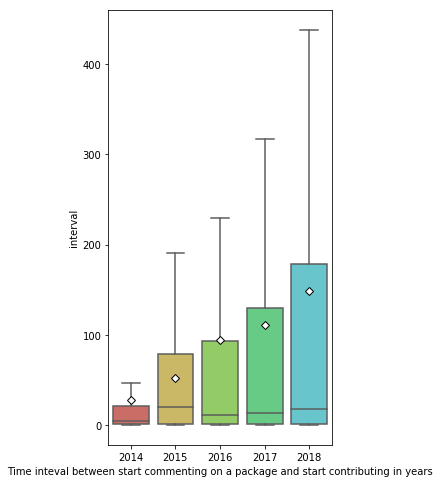

In [40]:
plt.rcParams["figure.figsize"] = (4,8)
fig, ax = plt.subplots()

seaborn.boxplot(
    x='year', 
    y='interval', 
    data=(
        comment_relation
        .assign(interval=lambda x: (x['created_at'] - x['comment_at']).dt.total_seconds()/3600/24)
        .assign(year=lambda x: x['created_at'].dt.year,axis=1)
        [['year','interval']]
    ),
    order=range(2014, 2019),
    palette=palet,
    ax=ax,
    fliersize=1,
    showmeans=True,
    showfliers=False,
    meanprops=dict(marker='D', markeredgecolor='black', markerfacecolor='white')
)

ax.set(
    xlabel='Time inteval between start commenting on a package and start contributing in years', 
)

[Text(0.5, 0, 'Time Interval between start commenting on a package and start contributing regarding comment type')]

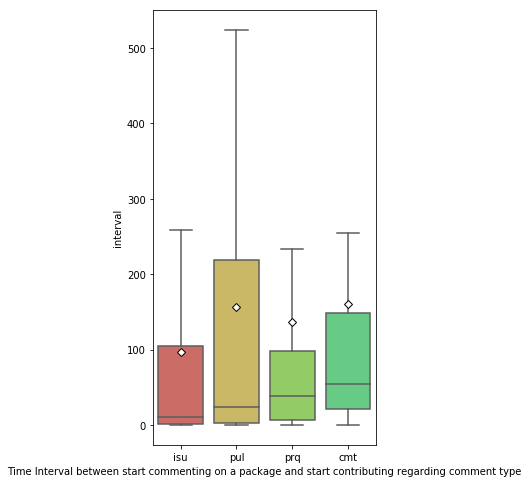

In [39]:
plt.rcParams["figure.figsize"] = (4,8)
fig, ax = plt.subplots()

seaborn.boxplot(
    x='cmt_type', 
    y='interval', 
    data=(
        comment_relation
        .assign(interval=lambda x: (x['created_at'] - x['comment_at']).dt.total_seconds()/3600/24)
        [['cmt_type','interval']]
    ),
    palette=palet,
    ax=ax,
    fliersize=1,
    showmeans=True,
    showfliers=False,
    meanprops=dict(marker='D', markeredgecolor='black', markerfacecolor='white')
)

ax.set(
    xlabel='Time Interval between start commenting on a package and start contributing regarding comment type', 
)

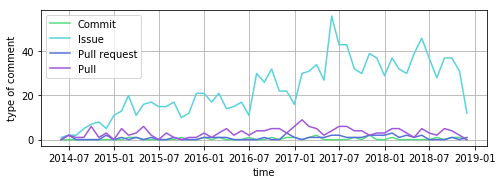

In [38]:
df_tmp = (
    comment_relation[['created_at','author_assoc','cmt_type']]
    .assign(count=1)
    .groupby([pandas.Grouper(key='created_at',freq='1M'),'cmt_type'])
    .sum()
    .unstack('cmt_type')
    .fillna(0).rename(columns={'cmt': 'Commit',
                               'pul': 'Pull',
                               'isu': 'Issue',
                               'prq': 'Pull request'})
)
df_tmp = df_tmp.xs('count', axis=1, drop_level=True).reset_index()
plt.rcParams["figure.figsize"] = (8,2.5)
fig, ax = plt.subplots()


for i in range(1,len(df_tmp.columns)):
    ax.plot(df_tmp['created_at'],df_tmp[df_tmp.columns[i]],color= palet[i+2])
ax.set_xlabel('time')
ax.set_ylabel('type of comment')
ax.grid(True)
ax.legend(('Commit','Issue','Pull request','Pull'))

*** what other types of analysis can be done in this question ?